In [1]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras import callbacks
import os
import cv2
import string
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt

#Init main values
symbols = string.ascii_lowercase + "0123456789" # All symbols captcha can contain
num_symbols = len(symbols)
img_shape = (50, 200, 1)

In [2]:
print(num_symbols)

36


In [3]:
def create_model():
    img = layers.Input(shape=img_shape) # Get image as an input and process it through some Convs
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img)
    mp1 = layers.MaxPooling2D(padding='same')(conv1)  # 100x25
    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)  # 50x13
    conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3)
    mp3 = layers.MaxPooling2D(padding='same')(bn)  # 25x7
    
    # Get flattened vector and make 5 branches from it. Each branch will predict one letter
    flat = layers.Flatten()(mp3)
    outs = []
    for _ in range(5):
        dens1 = layers.Dense(64, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dens1)
        res = layers.Dense(num_symbols, activation='sigmoid')(drop)

        outs.append(res)
    
    # Compile model and return it
    model = Model(img, outs)
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
    return model

Importing Data

In [4]:
def preprocess_data():
    n_samples = len(os.listdir('captcha-version-2-images/samples/samples'))
    X = np.zeros((n_samples, 50, 200, 1)) #1070*50*200
    y = np.zeros((5, n_samples, num_symbols)) #5*1070*36

    for i, pic in enumerate(os.listdir('captcha-version-2-images/samples/samples')):
        # Read image as grayscale
        img = cv2.imread(os.path.join('captcha-version-2-images/samples/samples', pic), cv2.IMREAD_GRAYSCALE)
        pic_target = pic[:-4]
        if len(pic_target) < 6:
            # Scale and reshape image
            img = img / 255.0
            img = np.reshape(img, (50, 200, 1))
            # Define targets and code them using OneHotEncoding
            targs = np.zeros((5, num_symbols))
            for j, l in enumerate(pic_target):
                ind = symbols.find(l)
                targs[j, ind] = 1
            X[i] = img
            y[:, i] = targs
    
    # Return final data
    return X, y

X, y = preprocess_data()
X_train, y_train = X[:970], y[:, :970]
X_test, y_test = X[970:], y[:, 970:]
print(str(len(X_train)) + " training samples")
print(str(len(X_test)) + " validation samples")


970 training samples
100 validation samples


In [5]:
model=create_model();
model.summary();

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 200, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 50, 200, 16)  160         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 25, 100, 16)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 25, 100, 32)  4640        max_pooling2d[0][0]              
______________________________________________________________________________________________

In [6]:
#model = create_model()
hist = model.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]], batch_size=32, epochs=30,verbose=1, validation_split=0.2)

Epoch 1/30
25/25 [==============================] - 5s 38ms/step - loss: 17.6682 - dense_1_loss: 3.4267 - dense_3_loss: 3.5796 - dense_5_loss: 3.5649 - dense_7_loss: 3.5992 - dense_9_loss: 3.4978 - dense_1_accuracy: 0.0735 - dense_3_accuracy: 0.0451 - dense_5_accuracy: 0.0503 - dense_7_accuracy: 0.0438 - dense_9_accuracy: 0.0696 - val_loss: 17.7506 - val_dense_1_loss: 3.6278 - val_dense_3_loss: 3.5343 - val_dense_5_loss: 3.5366 - val_dense_7_loss: 3.5329 - val_dense_9_loss: 3.5190 - val_dense_1_accuracy: 0.0000e+00 - val_dense_3_accuracy: 0.0722 - val_dense_5_accuracy: 0.0979 - val_dense_7_accuracy: 0.0567 - val_dense_9_accuracy: 0.1443
Epoch 2/30
25/25 [==============================] - 0s 16ms/step - loss: 16.1591 - dense_1_loss: 2.8476 - dense_3_loss: 3.2834 - dense_5_loss: 3.3157 - dense_7_loss: 3.3892 - dense_9_loss: 3.3233 - dense_1_accuracy: 0.1675 - dense_3_accuracy: 0.0760 - dense_5_accuracy: 0.0760 - dense_7_accuracy: 0.0657 - dense_9_accuracy: 0.0683 - val_loss: 17.6949 - va

Epoch 14/30
25/25 [==============================] - 0s 17ms/step - loss: 3.6851 - dense_1_loss: 0.2774 - dense_3_loss: 0.4825 - dense_5_loss: 0.6551 - dense_7_loss: 1.3439 - dense_9_loss: 0.9261 - dense_1_accuracy: 0.9008 - dense_3_accuracy: 0.8325 - dense_5_accuracy: 0.7693 - dense_7_accuracy: 0.5219 - dense_9_accuracy: 0.6778 - val_loss: 9.5981 - val_dense_1_loss: 3.8629 - val_dense_3_loss: 1.0521 - val_dense_5_loss: 1.4515 - val_dense_7_loss: 1.8446 - val_dense_9_loss: 1.3871 - val_dense_1_accuracy: 0.0773 - val_dense_3_accuracy: 0.8093 - val_dense_5_accuracy: 0.7268 - val_dense_7_accuracy: 0.6289 - val_dense_9_accuracy: 0.7423
Epoch 15/30
25/25 [==============================] - 0s 17ms/step - loss: 3.3936 - dense_1_loss: 0.2626 - dense_3_loss: 0.4859 - dense_5_loss: 0.6411 - dense_7_loss: 1.1554 - dense_9_loss: 0.8485 - dense_1_accuracy: 0.9072 - dense_3_accuracy: 0.8170 - dense_5_accuracy: 0.7616 - dense_7_accuracy: 0.6082 - dense_9_accuracy: 0.7152 - val_loss: 9.2373 - val_dens

Epoch 27/30
25/25 [==============================] - 0s 17ms/step - loss: 1.7994 - dense_1_loss: 0.1298 - dense_3_loss: 0.2677 - dense_5_loss: 0.3545 - dense_7_loss: 0.6646 - dense_9_loss: 0.3828 - dense_1_accuracy: 0.9459 - dense_3_accuracy: 0.8943 - dense_5_accuracy: 0.8698 - dense_7_accuracy: 0.7616 - dense_9_accuracy: 0.8621 - val_loss: 11.5996 - val_dense_1_loss: 8.5601 - val_dense_3_loss: 0.6702 - val_dense_5_loss: 0.8516 - val_dense_7_loss: 0.9606 - val_dense_9_loss: 0.5572 - val_dense_1_accuracy: 0.0876 - val_dense_3_accuracy: 0.8660 - val_dense_5_accuracy: 0.7680 - val_dense_7_accuracy: 0.7320 - val_dense_9_accuracy: 0.8505
Epoch 28/30
25/25 [==============================] - 0s 17ms/step - loss: 1.6686 - dense_1_loss: 0.1338 - dense_3_loss: 0.2738 - dense_5_loss: 0.3164 - dense_7_loss: 0.6268 - dense_9_loss: 0.3178 - dense_1_accuracy: 0.9446 - dense_3_accuracy: 0.9059 - dense_5_accuracy: 0.8802 - dense_7_accuracy: 0.7680 - dense_9_accuracy: 0.8905 - val_loss: 11.6937 - val_de

In [7]:
# Define function to predict captcha
def predict(filepath):
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = img / 255.0
    else:
        print("Not detected");
    res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis]))
    ans = np.reshape(res, (5, 36))
    l_ind = []
    probs = []
    for a in ans:
        l_ind.append(np.argmax(a))
        #probs.append(np.max(a))

    capt = ''
    for l in l_ind:
        capt += symbols[l]
    return capt#, sum(probs) / 5


In [9]:
score= model.evaluate(X_test,[y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]],verbose=1)
print('='*100)
print('Test Loss and accuracy:', score)

4/4 [==============================] - 0s 8ms/step - loss: 19.0624 - dense_1_loss: 17.0979 - dense_3_loss: 0.3333 - dense_5_loss: 0.6336 - dense_7_loss: 0.7759 - dense_9_loss: 0.2217 - dense_1_accuracy: 0.0000e+00 - dense_3_accuracy: 0.9000 - dense_5_accuracy: 0.8000 - dense_7_accuracy: 0.7600 - dense_9_accuracy: 0.9000
Test Loss and accuracy: [19.062355041503906, 17.09786605834961, 0.333297997713089, 0.6335598230361938, 0.7759488821029663, 0.22168105840682983, 0.0, 0.8999999761581421, 0.800000011920929, 0.7599999904632568, 0.8999999761581421]


In [11]:
# Check model on some samples
model.evaluate(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]])
print('='*100)
print(predict('captcha-version-2-images/samples/samples/8n5p3.png'))
print(predict('captcha-version-2-images/samples/samples/f2m8n.png'))
print(predict('captcha-version-2-images/samples/samples/dce8y.png'))
print(predict('captcha-version-2-images/samples/samples/3eny7.png'))
print(predict('captcha-version-2-images/samples/samples/npxb7.png'))

4/4 [==============================] - 0s 9ms/step - loss: 19.0624 - dense_1_loss: 17.0979 - dense_3_loss: 0.3333 - dense_5_loss: 0.6336 - dense_7_loss: 0.7759 - dense_9_loss: 0.2217 - dense_1_accuracy: 0.0000e+00 - dense_3_accuracy: 0.9000 - dense_5_accuracy: 0.8000 - dense_7_accuracy: 0.7600 - dense_9_accuracy: 0.9000
8n5p3
f2m8n
dce8y
3eny7
npxb7


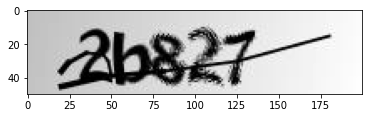

In [12]:
#Lets test an unknown captcha
#preview
%matplotlib inline 
import matplotlib.pyplot as plt
img=cv2.imread('captcha_images_v2/2b827.png',cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=plt.get_cmap('gray'))

In [13]:
#Lets Predict By Model
print("Predicted Captcha =",predict('captcha_images_v2/2b827.png'))

Predicted Captcha = 2b827
